In [198]:
import torch
import torchvision
import numpy as np

In [199]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [200]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('/files/', split='byclass',train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('/files/',split='byclass', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
print(type(train_loader))
print(np.size(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
1


In [201]:
for i, data in enumerate(train_loader):
        t, train_labels = data
        
for i, data in enumerate(test_loader):
        t, test_labels = data

In [211]:
print(type(train_labels))

<class 'torch.Tensor'>


In [202]:
# Convert data to numpy arrays and normalize images to the interval [0, 1]

train_loader = next(iter(train_loader))[0].numpy() / 255.0
test_loader = next(iter(test_loader))[0].numpy() / 255.0
print(type(train_loader))

<class 'numpy.ndarray'>


In [203]:
train_loader[0]

array([[[-1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03],
        [-1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.6635802e-03, -1.6635802e-03,
         -1.6635802e-03, -1.6635802e-03, -1.663580

In [204]:

#Reshaping all images into 28*28 for pre-processing
train_loader =train_loader.reshape(train_loader.shape[0], 28, 28)
test_loader = test_loader.reshape(test_loader.shape[0], 28, 28)
print(np.size(train_loader))
print(np.size(test_loader))

50176
784000


<function matplotlib.pyplot.show(*args, **kw)>

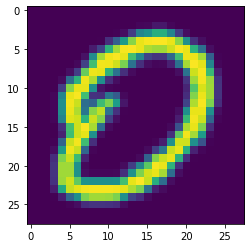

In [205]:

from matplotlib import pyplot as plt
#Display a random image
plt.imshow(test_loader[0])
plt.show

In [206]:
# a = np.array([1,2,3,4])
# s = []
# print(type(a))
# i=0
# for t in a:
#     s.append(t-1)
# print(s)
# print(type(s))

Process Complete: Rotated and reversed test and train images!


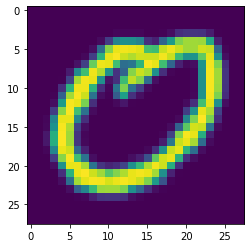

In [207]:
#Now we perform Image preprocessing. We reverse and rotate all train and test images
#for train data
s = []
for t in train_loader:
    s.append(np.transpose(t))
np.asarray(s)
train_loader = s

#checking
plt.imshow(train_loader[0])
plt.show

s=[]
#for test data  
for t in test_loader:
    s.append(np.transpose(t))
np.asarray(s)
test_loader = s
#checking
plt.imshow(test_loader[0])
plt.show

print('Process Complete: Rotated and reversed test and train images!')

In [213]:
# Converting back to dataloader form for giving it as input to model

tensor_tr = torch.Tensor(train_loader) # transform to torch tensor
tensor_te = torch.Tensor(test_loader)


tr_dataset = torch.utils.data.TensorDataset(tensor_tr,train_labels) # create your datset
train_loader = torch.utils.data.DataLoader(tr_dataset) # create your dataloader

te_dataset = torch.utils.data.TensorDataset(tensor_te,test_labels) # create your datset
test_loader = torch.utils.data.DataLoader(te_dataset) # create your dataloader

print(type(train_loader))
print(type(test_loader))

AssertionError: 

In [ ]:
# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples,test_labels)

In [ ]:
# example_data.shape

In [ ]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# for i in range(100,106):
#   plt.subplot(2,3,i+1-100)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [194]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#       torch.save(network.state_dict(), 'results/model.pth')
#       torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [195]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [196]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [ ]:
with torch.no_grad():
  output = network(example_data)

In [ ]:
fig = plt.figure()
for i in range(100,112):
  plt.subplot(3,4,i+1-100)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
